In [ ]:
!pip install ipywidgets

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
'''
{
  "label": {
    0: "hate-speech",
    1: "offensive-speech",
    2: "neither"
  },
  "tweet": <string>
}
'''
ds = load_dataset("badmatr11x/hate-offensive-speech")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

(…)-00000-of-00001-b57a122b095e5ed1.parquet:   0%|          | 0.00/3.49M [00:00<?, ?B/s]

(…)-00000-of-00001-9ea89a9fc1c6b387.parquet:   0%|          | 0.00/193k [00:00<?, ?B/s]

(…)-00000-of-00001-10d11e25d2e9ec6e.parquet:   0%|          | 0.00/198k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51070 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2837 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 51070
    })
    validation: Dataset({
        features: ['label', 'tweet'],
        num_rows: 2838
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 2837
    })
})

In [ ]:
data = pd.DataFrame(ds['test'])

In [ ]:
data.head()

,label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,1,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,1,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,1,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,1,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from datasets import load_dataset

# Load the tweet_hate dataset
# ds = load_dataset("cardiffnlp/super_tweeteval", "tweet_hate")

# # Convert the 'test' split to a pandas DataFrame
# df = pd.DataFrame(ds['test'])

# Initialize label mappings
label_mappings = {
    "facebook_roberta": {0: 'Neutral', 1: 'Hate'},
    "hatexplain": {0: 'Hate', 1: 'Neutral', 2: 'Offensive'},
    "distilroberta": {0: 'Hate', 1: 'Offensive', 2: 'Neutral'},
    "cardiff_roberta": {0: "hate_gender", 1: "hate_race", 2: "hate_sexuality",
                        3: "hate_religion", 4: "hate_origin", 5: "hate_disability",
                        6: "hate_age", 7: "Neutral"},
    "dehatebert": {0: 'Neutral', 1: 'Hate'}
}

# Initialize the list of models
models = {
    "facebook_roberta": "facebook/roberta-hate-speech-dynabench-r4-target",
    "hatexplain": "Hate-speech-CNERG/bert-base-uncased-hatexplain",
    "distilroberta": "badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification",
    "cardiff_roberta": "cardiffnlp/twitter-roberta-large-hate-latest",
    "dehatebert": "Hate-speech-CNERG/dehatebert-mono-english",
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to run each model and get predictions, with offloading after each model
def run_model(model_name, model_path, text_list):
    print(f"Running model: {model_name}")

    # Tokenize the input text and move it to the GPU
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load the model and tokenizer and Move the model to the GPU
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model = model.to(device)

    def print_memory_usage(message):
        allocated_memory = torch.cuda.memory_allocated(device) / 1024**3  # Convert to GB
        cached_memory = torch.cuda.memory_reserved(device) / 1024**3  # Convert to GB
        print(f"{message}: Allocated: {allocated_memory:.2f} GB, Cached: {cached_memory:.2f} GB")

    predictions_list = []
    batch_size = 32
    for i in range(0, len(text_list), batch_size):
        batch_text = text_list[i:i + batch_size]
        inputs = tokenizer(batch_text, padding=True, truncation=True, return_tensors="pt").to(device)

        # inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
        inputs = inputs.to(device)

        print_memory_usage("Before running model")

        # Run inference with no gradients
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted probabilities and labels
        probabilities = torch.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)

        print_memory_usage("After running model")

        # Convert predictions to a list of label names
        predictions_list.extend(predictions.tolist())


    # Offload the model to the CPU
    model = model.to('cpu')
    torch.cuda.empty_cache()  # Clear GPU cache after offloading
    print_memory_usage("After offloading model to CPU and clearing cache")
    label_list = [label_mappings[model_name][pred] for pred in predictions_list]
    return label_list

# Run all models and append the predictions as new columns to the DataFrame
for model_name, model_path in tqdm(models.items(), desc="Running models"):
    data[model_name] = run_model(model_name, model_path, data['tweet'].tolist())

# Display the updated DataFrame with model predictions
data.head()

Running models:   0%|                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

Running model: facebook_roberta
Before running model: Allocated: 0.47 GB, Cached: 0.52 GB
After running model: Allocated: 0.47 GB, Cached: 0.61 GB
Before running model: Allocated: 0.47 GB, Cached: 0.61 GB
After running model: Allocated: 0.47 GB, Cached: 0.61 GB
Before running model: Allocated: 0.47 GB, Cached: 0.61 GB
After running model: Allocated: 0.47 GB, Cached: 0.61 GB
Before running model: Allocated: 0.47 GB, Cached: 0.61 GB
After running model: Allocated: 0.47 GB, Cached: 0.81 GB
Before running model: Allocated: 0.47 GB, Cached: 0.81 GB
After running model: Allocated: 0.47 GB, Cached: 0.81 GB
Before running model: Allocated: 0.47 GB, Cached: 0.81 GB
After running model: Allocated: 0.47 GB, Cached: 0.81 GB
Before running model: Allocated: 0.47 GB, Cached: 0.81 GB
After running model: Allocated: 0.47 GB, Cached: 0.81 GB
Before running model: Allocated: 0.47 GB, Cached: 0.81 GB
After running model: Allocated: 0.47 GB, Cached: 0.81 GB
Before running model: Allocated: 0.47 GB, Cached

Running models:  20%|██████████████████████████████▍                                                                                                                         | 1/5 [00:06<00:24,  6.09s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: hatexplain


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Before running model: Allocated: 0.42 GB, Cached: 0.46 GB
After running model: Allocated: 0.48 GB, Cached: 0.61 GB
Before running model: Allocated: 0.48 GB, Cached: 0.61 GB
After running model: Allocated: 0.47 GB, Cached: 0.65 GB
Before running model: Allocated: 0.47 GB, Cached: 0.65 GB
After running model: Allocated: 0.45 GB, Cached: 0.65 GB
Before running model: Allocated: 0.45 GB, Cached: 0.65 GB
After running model: Allocated: 0.50 GB, Cached: 0.70 GB
Before running model: Allocated: 0.50 GB, Cached: 0.70 GB
After running model: Allocated: 0.46 GB, Cached: 0.70 GB
Before running model: Allocated: 0.46 GB, Cached: 0.70 GB
After running model: Allocated: 0.48 GB, Cached: 0.70 GB
Before running model: Allocated: 0.48 GB, Cached: 0.70 GB
After running model: Allocated: 0.45 GB, Cached: 0.70 GB
Before running model: Allocated: 0.45 GB, Cached: 0.70 GB
After running model: Allocated: 0.45 GB, Cached: 0.70 GB
Before running model: Allocated: 0.45 GB, Cached: 0.70 GB
After running model: A

Running models:  40%|████████████████████████████████████████████████████████████▊                                                                                           | 2/5 [00:10<00:14,  4.91s/it]

After offloading model to CPU and clearing cache: Allocated: 0.03 GB, Cached: 0.26 GB
Running model: distilroberta
Before running model: Allocated: 0.32 GB, Cached: 0.40 GB
After running model: Allocated: 0.32 GB, Cached: 0.45 GB
Before running model: Allocated: 0.32 GB, Cached: 0.45 GB
After running model: Allocated: 0.32 GB, Cached: 0.45 GB
Before running model: Allocated: 0.32 GB, Cached: 0.45 GB
After running model: Allocated: 0.32 GB, Cached: 0.45 GB
Before running model: Allocated: 0.32 GB, Cached: 0.45 GB
After running model: Allocated: 0.32 GB, Cached: 0.64 GB
Before running model: Allocated: 0.32 GB, Cached: 0.64 GB
After running model: Allocated: 0.32 GB, Cached: 0.64 GB
Before running model: Allocated: 0.32 GB, Cached: 0.64 GB
After running model: Allocated: 0.32 GB, Cached: 0.64 GB
Before running model: Allocated: 0.32 GB, Cached: 0.64 GB
After running model: Allocated: 0.32 GB, Cached: 0.64 GB
Before running model: Allocated: 0.32 GB, Cached: 0.64 GB
After running model: A

Running models:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3/5 [00:12<00:07,  3.94s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: cardiff_roberta
Before running model: Allocated: 1.33 GB, Cached: 1.34 GB
After running model: Allocated: 1.33 GB, Cached: 1.46 GB
Before running model: Allocated: 1.33 GB, Cached: 1.46 GB
After running model: Allocated: 1.33 GB, Cached: 1.46 GB
Before running model: Allocated: 1.33 GB, Cached: 1.46 GB
After running model: Allocated: 1.33 GB, Cached: 1.46 GB
Before running model: Allocated: 1.33 GB, Cached: 1.46 GB
After running model: Allocated: 1.33 GB, Cached: 1.77 GB
Before running model: Allocated: 1.33 GB, Cached: 1.77 GB
After running model: Allocated: 1.33 GB, Cached: 1.78 GB
Before running model: Allocated: 1.33 GB, Cached: 1.78 GB
After running model: Allocated: 1.33 GB, Cached: 1.78 GB
Before running model: Allocated: 1.33 GB, Cached: 1.78 GB
After running model: Allocated: 1.33 GB, Cached: 1.78 GB
Before running model: Allocated: 1.33 GB, Cached: 1.78 GB
After running model:

Running models:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4/5 [00:26<00:07,  7.62s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: dehatebert
Before running model: Allocated: 0.63 GB, Cached: 0.68 GB
After running model: Allocated: 0.63 GB, Cached: 0.77 GB
Before running model: Allocated: 0.63 GB, Cached: 0.77 GB
After running model: Allocated: 0.63 GB, Cached: 0.77 GB
Before running model: Allocated: 0.63 GB, Cached: 0.77 GB
After running model: Allocated: 0.63 GB, Cached: 0.77 GB
Before running model: Allocated: 0.63 GB, Cached: 0.77 GB
After running model: Allocated: 0.63 GB, Cached: 0.82 GB
Before running model: Allocated: 0.63 GB, Cached: 0.82 GB
After running model: Allocated: 0.63 GB, Cached: 0.82 GB
Before running model: Allocated: 0.63 GB, Cached: 0.82 GB
After running model: Allocated: 0.63 GB, Cached: 0.82 GB
Before running model: Allocated: 0.63 GB, Cached: 0.82 GB
After running model: Allocated: 0.63 GB, Cached: 0.82 GB
Before running model: Allocated: 0.63 GB, Cached: 0.82 GB
After running model: Allo

Running models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.10s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB


,label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,1,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,1,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,1,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,1,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [ ]:
data.to_excel('badmatr11x.xlsx',index=False)

In [ ]:
label={
    0: "Hate",
    1: "Offensive",
    2: "Neutral"
  }

data['label'] = data['label'].map(label)

In [ ]:
data.drop(columns=['label_cat'],axis=1,inplace=True)

In [ ]:
data.head()

,label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,Offensive,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,Offensive,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,Offensive,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,Neutral,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,Offensive,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [ ]:
df = data.copy()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/_Immigration LatinX'

/content/drive/.shortcut-targets-by-id/15qBLFlUf-o-58bi_3Y6CDVFEEswJT6DT/_Immigration LatinX


In [24]:
df = pd.read_excel('badmatr11x.xlsx')

In [25]:
df.head()

,label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,1,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,1,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,1,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,1,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [26]:
df.rename(columns={'label':'true_label'},inplace=True)

In [27]:
df.head()

,true_label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,1,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,1,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,1,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,1,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [21]:
df1 = df[df['true_label'] != 1]

<ipython-input-22-f18c94cdcb2f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cardiff_roberta_simplified'] = df1['cardiff_roberta'].map(label_mapping_cardiff)
<ipython-input-22-f18c94cdcb2f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cardiff_roberta_numeric'] = df1['cardiff_roberta_simplified'].map(label_mapping)


Cardiff Roberta (simplified) - Accuracy: 0.9091869060190074, F1 Score: 0.6828693698429572


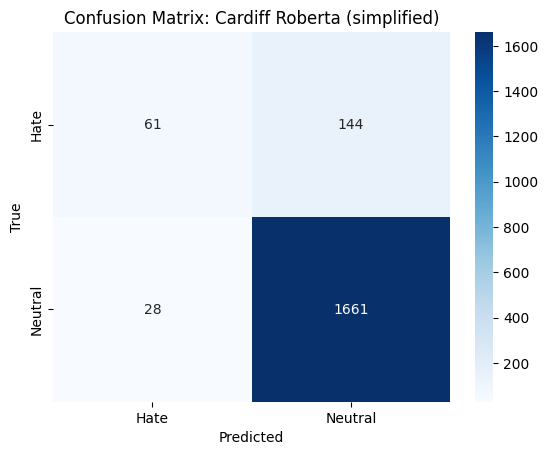

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and you want to simplify cardiff_roberta labels

# Mapping for cardiff_roberta, collapsing all hate categories into 'Hate'
label_mapping_cardiff = {
    "hate_gender": "Hate",
    "hate_race": "Hate",
    "hate_sexuality": "Hate",
    "hate_religion": "Hate",
    "hate_origin": "Hate",
    "hate_disability": "Hate",
    "hate_age": "Hate",
    "Neutral": "Neutral"
}

# Convert the 'cardiff_roberta' column to the new simplified label mapping
df1['cardiff_roberta_simplified'] = df1['cardiff_roberta'].map(label_mapping_cardiff)

# Convert the simplified labels to numeric values using the same mapping as before
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}

# Map the simplified labels to numeric values
df1['cardiff_roberta_numeric'] = df1['cardiff_roberta_simplified'].map(label_mapping)

# Calculate accuracy, F1 score, and confusion matrix
accuracy_cardiff = accuracy_score(df1['true_label'], df1['cardiff_roberta_numeric'])
f1_cardiff = f1_score(df1['true_label'], df1['cardiff_roberta_numeric'], average='macro')

# Print accuracy and F1 score
print(f"Cardiff Roberta (simplified) - Accuracy: {accuracy_cardiff}, F1 Score: {f1_cardiff}")

# Confusion Matrix for cardiff_roberta
cm_cardiff = confusion_matrix(df1['true_label'], df1['cardiff_roberta_numeric'])
sns.heatmap(cm_cardiff, annot=True, fmt="d", cmap="Blues", xticklabels=['Hate', 'Neutral'], yticklabels=['Hate', 'Neutral'])
plt.title("Confusion Matrix: Cardiff Roberta (simplified)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

HateXplain - Accuracy: 0.7751145576313007, F1 Score: 0.5536350012866683
DistilRoberta - Accuracy: 0.9517095523440254, F1 Score: 0.8844983101713019


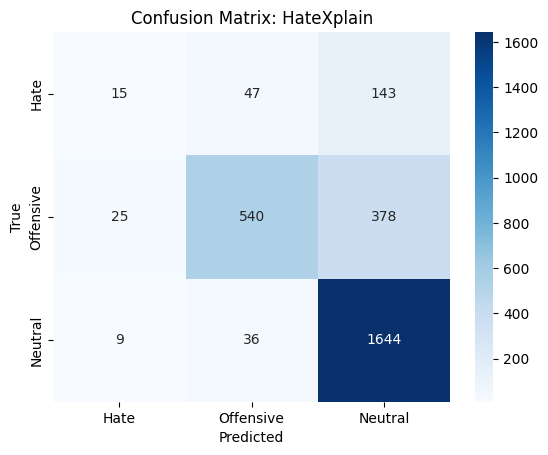

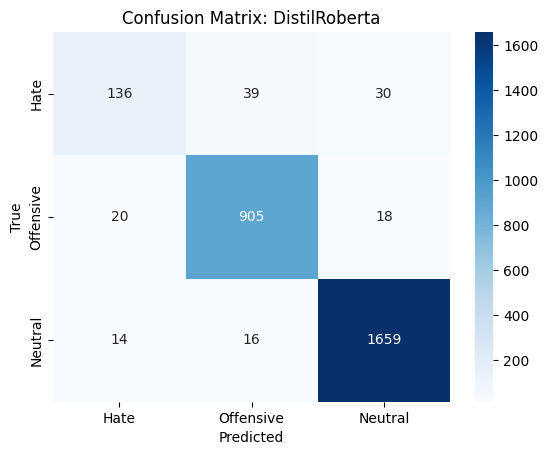

In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Mapping for hatexplain and distilroberta
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}

# Convert labels to numerical values for matching models
# df['true_label'] = df['label'].map(label_mapping)
df['hatexplain_numeric'] = df['hatexplain'].map(label_mapping)
df['distilroberta_numeric'] = df['distilroberta'].map(label_mapping)

# Calculate accuracy for facebook_roberta, hatexplain, and distilroberta
accuracy_hatexplain = accuracy_score(df['true_label'], df['hatexplain_numeric'])
accuracy_distilroberta = accuracy_score(df['true_label'], df['distilroberta_numeric'])

# Calculate F1 Scores (macro-averaged to account for multiple classes)
f1_hatexplain = f1_score(df['true_label'], df['hatexplain_numeric'], average='macro')
f1_distilroberta = f1_score(df['true_label'], df['distilroberta_numeric'], average='macro')

# Print Accuracy and F1 Scores
print(f"HateXplain - Accuracy: {accuracy_hatexplain}, F1 Score: {f1_hatexplain}")
print(f"DistilRoberta - Accuracy: {accuracy_distilroberta}, F1 Score: {f1_distilroberta}")

# Confusion Matrix for hatexplain
cm_hatexplain = confusion_matrix(df['true_label'], df['hatexplain_numeric'])
sns.heatmap(cm_hatexplain, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: HateXplain")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix for distilroberta
cm_distilroberta = confusion_matrix(df['true_label'], df['distilroberta_numeric'])
sns.heatmap(cm_distilroberta, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: DistilRoberta")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [8]:
df1 = df[df['label'] != 'Offensive']
df1.head()

,label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,1,That boy has always been a pussy never been a ...,Hate,Offensive,Offensive,Neutral,Hate
1,1,RT @koleworld4: every time i come out im never...,Hate,Offensive,Offensive,Neutral,Neutral
2,1,Ayee hoe,Hate,Offensive,Offensive,hate_gender,Hate
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral
4,1,hahaha my girl just popped on a bitch like a M...,Hate,Offensive,Offensive,hate_gender,Hate


In [29]:
df1.head()

,true_label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert,cardiff_roberta_simplified,cardiff_roberta_numeric
3,2,wasn't i supposed 2 saveð..but then i thoug...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,2
6,2,after the vacation its tym fr get bck to my bo...,Hate,Neutral,Neutral,Neutral,Neutral,Neutral,2
7,2,@user #motivation tip #5! choose to be ! #mo...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,2
8,2,#newstar bull up: you will dominate your bul...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,2
11,2,ugh. watching my play through of #deadbydayli...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,2


Facebook Roberta - Accuracy: 0.8912354804646251, F1 Score: 0.704241964827168
Dehatebert - Accuracy: 0.8236536430834214, F1 Score: 0.6561140973454407


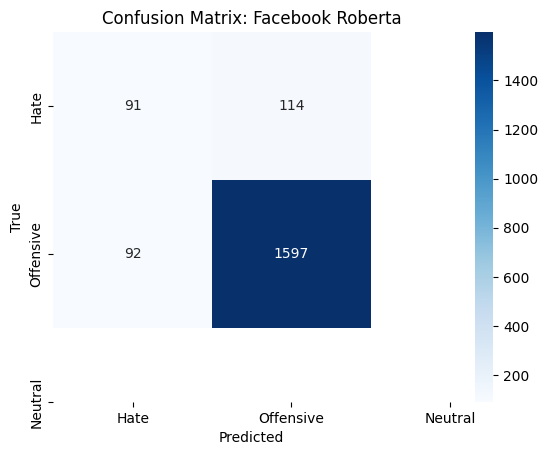

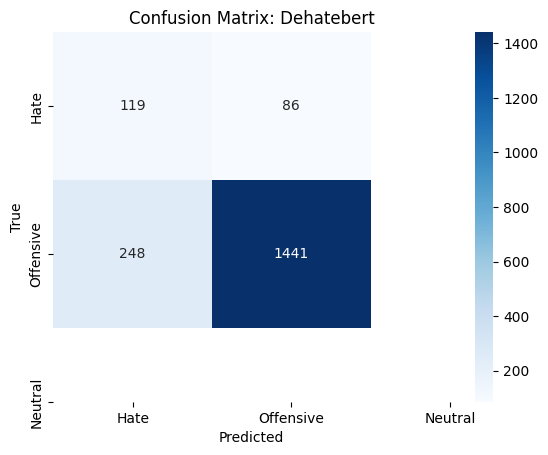

In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# df1 = df[df['label'] != '1'] Already done above
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}
# df1['true_label'] = df1['label'].map(label_mapping)
df1['facebook_roberta_numeric'] = df1['facebook_roberta'].map(label_mapping)
df1['dehatebert_numeric'] = df1['dehatebert'].map(label_mapping)
#accuracy
accuracy_facebook = accuracy_score(df1['true_label'], df1['facebook_roberta_numeric'])
accuracy_dehatebert = accuracy_score(df1['true_label'], df1['dehatebert_numeric'])

#F1
f1_facebook = f1_score(df1['true_label'], df1['facebook_roberta_numeric'], average='macro')
f1_dehatebert = f1_score(df1['true_label'], df1['dehatebert_numeric'], average='macro')
#Print scores
print(f"Facebook Roberta - Accuracy: {accuracy_facebook}, F1 Score: {f1_facebook}")
print(f"Dehatebert - Accuracy: {accuracy_dehatebert}, F1 Score: {f1_dehatebert}")

# Confusion Matrix for facebook_roberta
cm_facebook = confusion_matrix(df1['true_label'], df1['facebook_roberta_numeric'])
sns.heatmap(cm_facebook, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: Facebook Roberta")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix for dehatebert
cm_dehatebert = confusion_matrix(df1['true_label'], df1['dehatebert_numeric'])
sns.heatmap(cm_dehatebert, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: Dehatebert")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
